### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
model_path = base_path + "model_runs/"
# load_name = "toy_quanta_test"  
# load_name = "dist_quanta_60dist_6s_12t_x2p5w"
# rev_name = "dist_quanta_60dist_12s_6t_x2p5w"
# load_name = "dist_quanta_60dist_6s_12t_no_scale"
# rev_name = "dist_quanta_60dist_12s_6t_no_scale"
# load_name = "dist_quanta_60dist_6s_12t_x2w_12kv"
# rev_name = "dist_quanta_60dist_12s_6t_x2w_12kv"
load_name = "dist_quanta_60rep_6s_12t_x2w_12kv"
# rev_name = "dist_quanta_60rep_12t_6s_x2w_12kv"
rev_name = "dist_quanta_60rep_6t_12s_x2w_12kv"

In [14]:
with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
    data = {
        int(rep): {
            cond: {
                sac: {
                    metric : f[rep][cond]["data"]["term"][sac][metric][:]
                    for metric in f[rep][cond]["data"]["term"][sac].keys()
                }
                for sac in f[rep][cond]["data"]["term"].keys()
            }
            for cond in f[rep].keys()
        }
        for rep in f.keys()
    }
    first_cond = list(data[0].keys())[0]
    bp_locs = {"sust": [], "trans": []}
    for rep in f.keys():
        params = json.loads(f[rep][first_cond]["model_params"][()])
        bp_locs["sust"].append(params["a"]["bp_locs"]["sust"])
        bp_locs["trans"].append(params["a"]["bp_locs"]["trans"])
    bp_locs = {k: np.array(v) for k, v in bp_locs.items()}
                            
    model_params = json.loads(f["0"][first_cond]["model_params"][()])
    exp_params = json.loads(f["0"][first_cond]["exp_params"][()])
    
if rev_name is not None:
    with h5.File(os.path.join(model_path, rev_name + ".h5"), "r") as f:
        rev = {
            int(rep): {
                cond: {
                    sac: {
                        metric : f[rep][cond]["data"]["term"][sac][metric][:]
                        for metric in f[rep][cond]["data"]["term"][sac].keys()
                    }
                    for sac in f[rep][cond]["data"]["term"].keys()
                }
                for cond in f[rep].keys()
            }
            for rep in f.keys()
        }
        rev_bp_locs = {"sust": [], "trans": []}
        for rep in f.keys():
            params = json.loads(f[rep][first_cond]["model_params"][()])
            rev_bp_locs["sust"].append(params["a"]["bp_locs"]["sust"])
            rev_bp_locs["trans"].append(params["a"]["bp_locs"]["trans"])
        rev_bp_locs = {k: np.array(v) for k, v in rev_bp_locs.items()}
    
dt = exp_params["dt"]
rec_xaxis = np.arange(0, exp_params["tstop"] + dt, dt)
velocities = exp_params["velocities"]
rec_shape = data[0][first_cond]["a"]["cai"].shape
print("dt = %.2f ms" % dt)
print("recording shape =", rec_shape)

dt = 1.00 ms
recording shape = (1, 10, 6001)


In [15]:
ding_soma_dist_bins = np.arange(0, 170, 10)
# bin_size = ding_soma_dist[1] - ding_soma_dist[0]  # shift over so points are ends of bins
# shifted_dist = np.concatenate([[0], bin_size + ding_soma_dist])
coverage = {
    "sust": np.array([4, 15, 32, 17, 14, 11, 2, 6, 5, 4, 4, 3, 1, 0, 0, 0]),
    "trans": np.array([0, 5, 10, 7, 13, 11, 12, 6, 23, 19, 10, 8, 5, 4, 1, 1])
}
concat_coverage = np.concatenate([coverage["sust"], coverage["trans"]])
sample_hist = lambda sample: np.histogram(sample, ding_soma_dist_bins)[0]

In [16]:
bp_hists = {
    bp: np.array([sample_hist(trial) for trial in locs]) 
    for bp, locs in bp_locs.items()
}
bp_entropy = {
    bp: np.array([stats.entropy(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in bp_hists.items()
}
concat_entropy = np.array([
    stats.entropy(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(bp_hists["sust"], bp_hists["trans"])
])
avg_entropy = (bp_entropy["sust"] + bp_entropy["trans"]) / 2

bp_mutual = {
    bp: np.array([metrics.mutual_info_score(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in bp_hists.items()
}
concat_mutual = np.array([
    metrics.mutual_info_score(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(bp_hists["sust"], bp_hists["trans"])
])
avg_mutual = (bp_mutual["sust"] + bp_mutual["trans"]) / 2

bp_means = {
    bp: np.mean(locs, axis=1)
    for bp, locs in bp_locs.items()
}
bp_medians = {
    bp: np.median(locs, axis=1)
    for bp, locs in bp_locs.items()
}

In [27]:
rev_bp_hists = {
    bp: np.array([sample_hist(trial) for trial in locs]) 
    for bp, locs in rev_bp_locs.items()
}
rev_bp_entropy = {
    bp: np.array([stats.entropy(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in rev_bp_hists.items()
}
rev_concat_entropy = np.array([
    stats.entropy(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(rev_bp_hists["sust"], rev_bp_hists["trans"])
])
rev_avg_entropy = (rev_bp_entropy["sust"] + rev_bp_entropy["trans"]) / 2

rev_bp_mutual = {
    bp: np.array([metrics.mutual_info_score(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in rev_bp_hists.items()
}
rev_concat_mutual = np.array([
    metrics.mutual_info_score(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(rev_bp_hists["sust"], rev_bp_hists["trans"])
])
rev_avg_mutual = (rev_bp_mutual["sust"] + rev_bp_mutual["trans"]) / 2

rev_bp_means = {
    bp: np.mean(locs, axis=1)
    for bp, locs in rev_bp_locs.items()
}
rev_bp_medians = {
    bp: np.median(locs, axis=1)
    for bp, locs in rev_bp_locs.items()
}

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [18]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["a"]["v"]),
                peak_vm_deflection(exp["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["a"]["v"], thresh),
                thresholded_area(exp["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["a"]["ica"] * -1, axis=-1),
                np.sum(exp["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["a"]["cai"], axis=-1),
                np.max(exp["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in data.items()
}

if rev_name is not None:
    for i in rev.keys():
        dsis[i]["no_gaba_rev"] = {
            "peak": pn_dsi(
                peak_vm_deflection(rev[i]["no_gaba"]["a"]["v"]),
                peak_vm_deflection(rev[i]["no_gaba"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(rev[i]["no_gaba"]["a"]["v"], thresh),
                thresholded_area(rev[i]["no_gaba"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(rev[i]["no_gaba"]["a"]["ica"] * -1, axis=-1),
                np.sum(rev[i]["no_gaba"]["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(rev[i]["no_gaba"]["a"]["cai"], axis=-1),
                np.max(rev[i]["no_gaba"]["b"]["cai"], axis=-1)
            ),
        }

dsis = {
    cond: {
        metric: np.concatenate([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

In [19]:
print("dsi metric shape =", dsis[first_cond]["peak_[Ca]"].shape)

dsi metric shape = (60, 10)


<IPython.core.display.Javascript object>


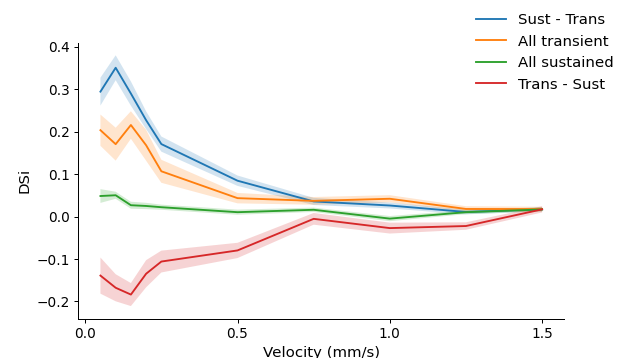

In [20]:
st_no_gaba_mean = np.mean(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_std = np.std(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_ste = st_no_gaba_std / np.sqrt(dsis["no_gaba"]["peak_[Ca]"].shape[0])
no_gaba_trans_mean = np.mean(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_std = np.std(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_ste = no_gaba_trans_std / np.sqrt(dsis["no_gaba_trans"]["peak_[Ca]"].shape[0])
no_gaba_sust_mean = np.mean(dsis["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_std = np.std(dsis["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_ste = no_gaba_sust_std / np.sqrt(dsis["no_gaba_sust"]["peak_[Ca]"].shape[0])

peak_ca_fig, peak_ca_ax = plt.subplots(1, figsize=(7, 4))
peak_ca_ax.fill_between(
    velocities, st_no_gaba_mean + st_no_gaba_ste, st_no_gaba_mean - st_no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, st_no_gaba_mean, label="Sust - Trans")
peak_ca_ax.fill_between(
    velocities, no_gaba_trans_mean + no_gaba_trans_ste, no_gaba_trans_mean - no_gaba_trans_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_trans_mean, label="All transient")
peak_ca_ax.fill_between(
    velocities, no_gaba_sust_mean + no_gaba_sust_ste, no_gaba_sust_mean - no_gaba_sust_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_sust_mean, label="All sustained")

if rev_name is not None:
    ts_no_gaba_mean = np.mean(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_std = np.std(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_ste = ts_no_gaba_std / np.sqrt(dsis["no_gaba_rev"]["peak_[Ca]"].shape[0])
    peak_ca_ax.fill_between(
        velocities, ts_no_gaba_mean + ts_no_gaba_ste, ts_no_gaba_mean - ts_no_gaba_ste, alpha=0.2)
    peak_ca_ax.plot(velocities, ts_no_gaba_mean, label="Trans - Sust")

peak_ca_ax.set_ylabel("DSi", fontsize=12)
peak_ca_ax.set_xlabel("Velocity (mm/s)", fontsize=12)
peak_ca_ax.set_xticks([0., 0.5, 1., 1.5])
# peak_ca_ax.set_yticks([0., 0.15, 0.3])
clean_axes(peak_ca_ax)
peak_ca_fig.legend(fontsize=12, frameon=False)
peak_ca_fig.show()

for ext in [".svg", ".png"]:
    peak_ca_fig.savefig(
        os.path.join(model_path, "velocity_falloff" + ext), bbox_inches="tight")

<IPython.core.display.Javascript object>


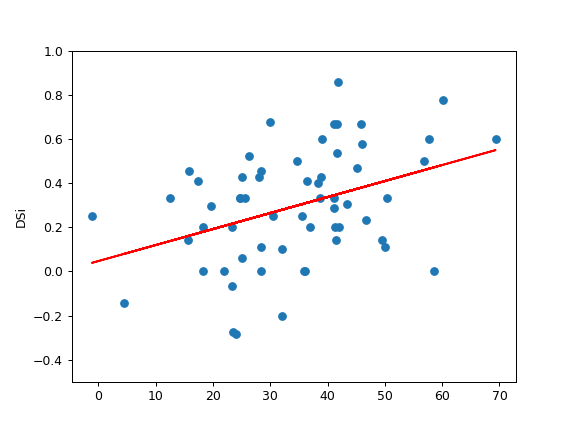

R-squared: 0.150471


Text(0, 0.5, 'DSi')

In [38]:
vel_idx = 0
ff, aa = plt.subplots(1)
# x = avg_entropy
# x = concat_entropy
# x = concat_mutual
# x = bp_medians["trans"] - bp_medians["sust"]
x = bp_means["trans"] - bp_means["sust"]
# x = bp_means["trans"]
# x = bp_means["sust"]
y = dsis["no_gaba"]["peak_[Ca]"][:, vel_idx]
res = stats.linregress(x, y) 
print(f"R-squared: {res.rvalue ** 2:.6f}")
aa.scatter(x, y)
aa.plot(x, res.intercept + res.slope*x, c="r")
aa.set_ylim(-0.5, 1)
aa.set_ylabel("DSi")
# aa.set_xlim(0, 1)

<IPython.core.display.Javascript object>


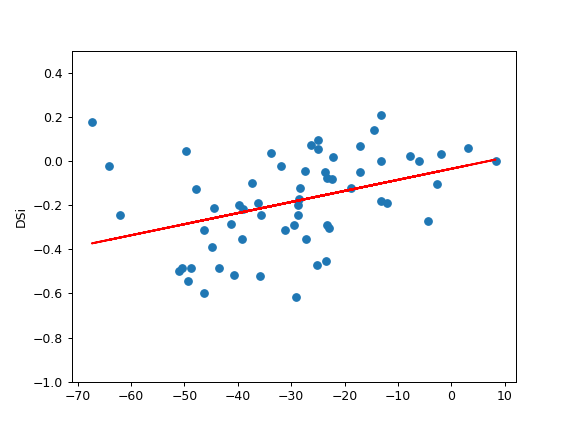

R-squared: 0.151341


Text(0, 0.5, 'DSi')

In [39]:
rev_vel_idx = 2
fff, aaa = plt.subplots(1)
# x = rev_avg_entropy
# x = rev_concat_entropy
# x = rev_concat_mutual
# x = rev_bp_medians["trans"] - rev_bp_medians["sust"]
x = rev_bp_means["trans"] - rev_bp_means["sust"]
# x = rev_bp_means["trans"]
# x = rev_bp_means["sust"]
y = dsis["no_gaba_rev"]["peak_[Ca]"][:, rev_vel_idx]
res = stats.linregress(x, y) 
print(f"R-squared: {res.rvalue ** 2:.6f}")
aaa.scatter(x, y)
aaa.plot(x, res.intercept + res.slope*x, c="r")
aaa.set_ylim(-1., 0.5)
aaa.set_ylabel("DSi")
# aa.set_xlim(0, 1)